In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
rs=121
ns=5
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [4]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','Volatility','HighR','LowR']
target='State'

In [5]:
#With TimeSeries
#First Set Aside Testing data
final_test=[]
l=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    l.append(x[1][:-ft_size])

In [6]:
def createSlidingWindow(tr,te,f,t, window=7):
    splitting=SlidingWindowSplitter(window_length=window,step_length=1,fh=[1])
    train_x=[]
    train_y=[]
    test_x=[]
    test_y=[]
    
    for i in splitting.split(tr):
        train_x.append(tr.iloc[i[0]][f].values.flatten())
        train_y.append(tr.iloc[i[1]][t].values.flatten()[0])
    
    for i in splitting.split(te):
        test_x.append(te.iloc[i[0]][f].values.flatten())
        test_y.append(te.iloc[i[1]][t].values.flatten()[0])
    return ((train_x,train_y),(test_x,test_y))

In [15]:
testing_size=500

tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
training_list=[]
testing_list=[]
for i in range(ns):
    training_list.append([[],[]])
    testing_list.append([[],[]])
training_lists = {}
testing_lists = {}
for spread in range(7,21):
    for x in l:
        for (i,t) in enumerate(tss.split(x)):
            ((train_x,train_y),(test_x,test_y))=createSlidingWindow(x.iloc[t[0]],x.iloc[t[1]],features,target, window = spread)
            training_list[i][0] += train_x
            training_list[i][1] += train_y
            testing_list[i][0] += test_x
            testing_list[i][1] += test_y
    training_lists[spread] = training_list
    testing_lists[spread] = testing_list
    training_list=[]
    testing_list=[]
    for i in range(ns):
        training_list.append([[],[]])
        testing_list.append([[],[]])

In [16]:
with open('saved_training_lists.pkl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_lists.pkl', 'wb') as f:
    pickle.dump(testing_lists, f)


In [48]:
with open('saved_training_lists.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [7]:
def accuracies_model(model):
    accuracies = {}
    for window in training_lists.keys():
        training_list = training_lists[window]
        testing_list = testing_lists[window]
        a=0 
        for i in range(ns):
            model.fit(X=training_list[i][0],y=training_list[i][1])
            a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
        a=a/ns
        accuracies[window] = a
    return accuracies

In [8]:
model_names=['ada','decisiontree']
training_list  = training_lists[13]
testing_list = testing_lists[13]
accuracies=[]
models=[AdaBoostClassifier(n_estimators=200,random_state=121),DecisionTreeClassifier(random_state=rs)]
#Add Possible AdaBoostModels:
for m in models:
    a=0
    for i in range(ns):
        m.fit(X=training_list[i][0],y=training_list[i][1])
        a+= accuracy_score(m.predict(testing_list[i][0]),testing_list[i][1])
    a=a/ns
    accuracies.append(a)

NameError: name 'training_lists' is not defined

In [18]:
accuracies

[0.7651510706952186, 0.6777354062775007]

In [19]:
training_lists.keys()

dict_keys([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [ ]:
model_names=['ada','decisiontree']
models=[AdaBoostClassifier(n_estimators=220,learning_rate=1,random_state=rs)]
#Add Possible AdaBoostModels:
for ind, m in enumerate(models):
    acc_model = accuracies_model(m)
    plot_accuracies(acc_model, model_names[ind])

NameError: name 'plot_accuracies' is not defined

In [21]:
def plot_accuracies(accuracies, model_type):
    plt.figure(figsize=(6, 4))
    plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
    plt.title(f"{model_type} accuracy scores")
    plt.xlabel("Window size")
    plt.ylabel("accuracy")
    plt.tight_layout()
    plt.show()

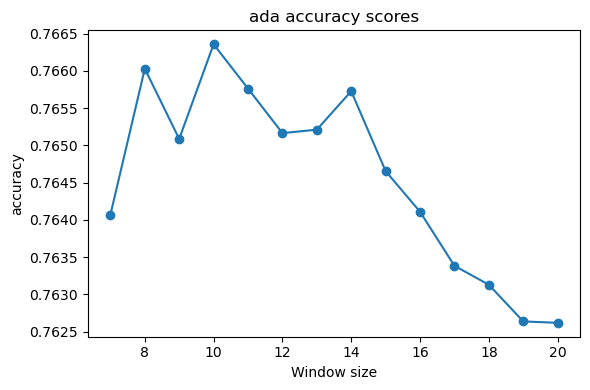

In [22]:
plot_accuracies(acc_model, model_names[ind])

In [19]:
#13 seems best from above
window=13
model=AdaBoostClassifier()

parameters = {
    'n_estimators' : [ 180, 200,220],
    'learning_rate' : [1,10]
}
grid_search = GridSearchCV(model, parameters, cv = 5, n_jobs=-1)
training_list = training_lists[window]
testing_list = testing_lists[window]
a=[] 
for i in range(ns):
    grid_search.fit(X=training_list[i][0],y=training_list[i][1])
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    a.append(grid_search.cv_results_)

    #a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
#a=a/ns

AdaBoostClassifier(learning_rate=1, n_estimators=220)
0.8191994720131739
AdaBoostClassifier(learning_rate=1, n_estimators=200)
0.836738932314244
AdaBoostClassifier(learning_rate=1, n_estimators=180)
0.8448664639503141
AdaBoostClassifier(learning_rate=1, n_estimators=220)
0.850352636201106
AdaBoostClassifier(learning_rate=1, n_estimators=220)
0.8507606993751269


In the below:
training_list: -> List of stocks -> List of timeseriessplit -> [train_x, train_y] -> train_x has shape (_,13x4) (_ is determined by which timesplit we're in), train_y has shape (_,1)

In [9]:
testing_size=500

tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
training_list=[]
testing_list=[]
for j in range(len(l)):
    ttl=[]
    tstl=[]
    for i in range(ns):
        ttl.append([[],[]])
        tstl.append([[],[]])
    training_list.append(ttl)
    testing_list.append(tstl)
spread = 13
for (j,x) in enumerate(l):
    for (i,t) in enumerate(tss.split(x)):
        ((train_x,train_y),(test_x,test_y))=createSlidingWindow(x.iloc[t[0]],x.iloc[t[1]],features,target, window = spread)
        training_list[j][i][0] += train_x
        training_list[j][i][1] += train_y
        testing_list[j][i][0] += test_x
        testing_list[j][i][1] += test_y


In [35]:
stock_accuracies={}
model=AdaBoostClassifier(n_estimators=220,learning_rate=1,random_state=rs)
for (j,x) in enumerate(l):
    a=0
    for i in range(ns):
        model.fit(X=training_list[j][i][0],y=training_list[j][i][1])
        a+=accuracy_score(model.predict(testing_list[j][i][0]),testing_list[j][i][1])
    stock_accuracies[x['Ticker'].iloc[0]]=a/ns

In [36]:
stock_accuracies

{'aapl': 0.8710472279260781,
 'cvx': 0.857905544147844,
 'dal': 0.942094455852156,
 'googl': 0.686652977412731,
 'nvda': 0.6271047227926078,
 'vz': 0.8788501026694047,
 'xom': 0.8574948665297741}

RNN Stuff

In [103]:
def createSlidingWindowRNN(tr,te,f,t, window=7):
    splitting=SlidingWindowSplitter(window_length=window,step_length=1,fh=[1])
    train_x=[]
    train_y=[]
    test_x=[]
    test_y=[]
    
    for i in splitting.split(tr):
        train_x.append(tr.iloc[i[0]][f].values)
        train_y.append(tr.iloc[i[1]][t].values)
    
    for i in splitting.split(te):
        test_x.append(te.iloc[i[0]][f].values)
        test_y.append(te.iloc[i[1]][t].values)
    return ((train_x,train_y),(test_x,test_y))

In [104]:
testing_size=500

tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
training_list=[]
testing_list=[]
for j in range(len(l)):
    ttl=[]
    tstl=[]
    for i in range(ns):
        ttl.append([[],[]])
        tstl.append([[],[]])
    training_list.append(ttl)
    testing_list.append(tstl)
spread = 13
for (j,x) in enumerate(l):
    for (i,t) in enumerate(tss.split(x)):
        ((train_x,train_y),(test_x,test_y))=createSlidingWindowRNN(x.iloc[t[0]],x.iloc[t[1]],features,target, window = spread)
        training_list[j][i][0] += train_x
        training_list[j][i][1] += train_y
        testing_list[j][i][0] += test_x
        testing_list[j][i][1] += test_y

In [85]:
len(training_list[0])

5

In [244]:
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN, SimpleRNN
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Activation
from keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

def build_model(train,test):
	# prepare data
	print(len(train))
	train_x, train_y = np.array(train[0]),np.array(train[1])
	test_x, test_y=np.array(test[0]),np.array(test[1])
	print(len(train_x), len(train_y))
	# define pa1rameters
	verbose, epochs, batch_size = 1, 60, 128
	n_timesteps, n_features, n_outputs = len(train_x[0]), len(train_x[0][0]), len(train_y[0])
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=False))
	#model.add(Dense(100, activation='relu'))
	model.add(Dropout(0.8, seed=121))
	model.add(Dense(n_outputs,activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=(test_x,test_y))
	return model


In [197]:
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [239]:
model=build_model(training_list[0][-1],testing_list[0][-1])

2
4917 4917
Epoch 1/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6604 - loss: 0.6251 - val_accuracy: 0.8029 - val_loss: 0.4486
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7759 - loss: 0.4680 - val_accuracy: 0.8296 - val_loss: 0.4237
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8042 - loss: 0.4348 - val_accuracy: 0.8316 - val_loss: 0.4198
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8135 - loss: 0.4245 - val_accuracy: 0.8255 - val_loss: 0.4152
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8187 - loss: 0.4144 - val_accuracy: 0.8296 - val_loss: 0.4003
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8208 - loss: 0.4140 - val_accuracy: 0.8255 - val_loss: 0.4069
Epoch 7/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8136 - loss: 0.4186 - val_accuracy: 0.8214 - val_loss: 0.4066
Epoch 8/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8152 - loss: 0.4096 - val_accuracy

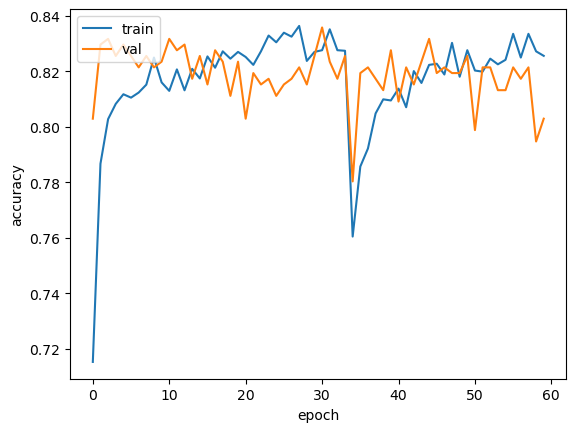

In [240]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [230]:
test_output = np.floor(model.predict(np.array(testing_list[0][-1][0]))*2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [243]:
accuracy_score(test_output,np.array(testing_list[0][-1][1]).astype(float))

0.17248459958932238

In [242]:
accuracy_score([0]*len(testing_list[0][-1][1]),np.array(testing_list[0][-1][1]).astype(float))

0.6591375770020534